# Negative Laplacian experiment

This code attempts to learn a Laplacian prior $J(x) = -|x|$ assuming we have access to a bunch of observations $S(yi) = min_{x \in \R} \{0.5||x-yi||^{2}_{2} + J(x)\}$.

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set seed
np.random.seed(1)
torch.manual_seed(1)

# Parameters and auxiliary functions

In [7]:
# Dimension of the LPN
dim = 1

# proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1

def cvx_true(y):
    val = 0.5*pow(y,2) + np.abs(y) + 0.5
    return val

def prior_true(y):
    val = -np.abs(y)
    return val

def prox_true(y):
    val = 0.0
    val = val + (y-1) * (y<0) + (y+1) * (y>0)
    return val

# function to plot learned prox, convex function, original function
def plot_all(model):
    xi = np.linspace(-4, 4, 1000)
    
    y = prox(xi, model)
    c = cvx(xi, model)
    p = prior(xi, model)

    plt.rcParams["figure.figsize"] = (8, 3)

    # learned prox
    plt.subplot(1, 3, 1)
    plt.plot(xi, y, "-", ms=5, label="LPN")
    plt.plot(xi, prox_true(xi), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # convex function
    plt.subplot(1, 3, 2)
    plt.plot(xi, c, "-", ms=5, label="Cvx func")
    plt.plot(xi, cvx_true(xi), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # original function
    plt.subplot(1, 3, 3)
    plt.plot(xi, p, label="LPN")
    plt.plot(xi, prior_true(xi), "--", label="ref", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Original func")

    plt.tight_layout()


## Model parameters

In [8]:
beta = 10  # beta of softplus
hidden = 50  # number of hidden units
layers = 10  # number of layers

# Generate sample points uniformly in the interval [a,b]
bsize = 200
a = -5.0
b = 5.0

input = torch.distributions.uniform.Uniform(a, b, validate_args=None).sample((bsize,))
input = input.unsqueeze(1).to(device)

# Evaluate the solution of the HJ PDE at these points
# Convert to pytorch
cvx_samples = cvx_true(input)

## Training function

In [9]:
def single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss=None):
    # Compute the convex function from the input
    cvx_out = lpn_model.scalar(input)

    

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / bsize  # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / bsize  # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")



    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss

iteration 0 loss 53.6871337890625
iteration 0 loss 303234.59375
iteration 500 loss 3702.034423828125
iteration 1000 loss 1025.690673828125
iteration 1500 loss 429.8877258300781
iteration 2000 loss 212.09774780273438
iteration 2500 loss 112.90902709960938
iteration 3000 loss 62.436397552490234
iteration 3500 loss 35.085609436035156
iteration 4000 loss 19.88325309753418
iteration 4500 loss 11.42577838897705
iteration 5000 loss 6.815545082092285
iteration 5500 loss 4.401665687561035
iteration 6000 loss 3.214749336242676
iteration 6500 loss 2.6728272438049316
iteration 7000 loss 2.4303996562957764
iteration 7500 loss 2.293657064437866
iteration 8000 loss 2.1650867462158203
iteration 8500 loss 2.0079991817474365
iteration 9000 loss 1.814993143081665
iteration 9500 loss 1.5874197483062744
iteration 10000 loss 1.3328351974487305
iteration 10500 loss 1.0639744997024536
iteration 11000 loss 0.7999405860900879
iteration 11500 loss 0.5639035701751709
iteration 12000 loss 0.3750041127204895
iterat

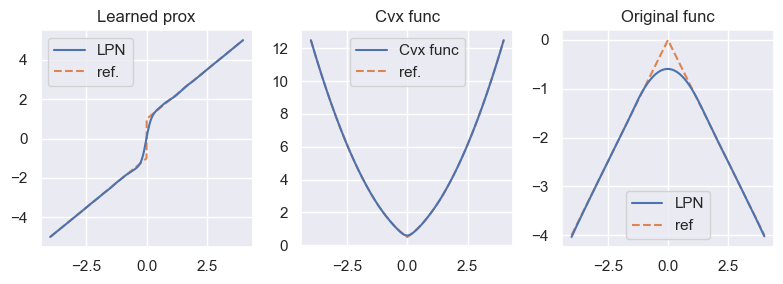

In [10]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(40000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

L1 loss

iteration 0 loss 6.157546520233154
iteration 0 loss 382.8653869628906
iteration 500 loss 6.544498920440674
iteration 1000 loss 0.8985386490821838
iteration 1500 loss 0.6673285961151123
iteration 2000 loss 0.39776843786239624
iteration 2500 loss 0.23856328427791595
iteration 3000 loss 0.15859268605709076
iteration 3500 loss 0.08765950798988342
iteration 4000 loss 0.05954568460583687
iteration 4500 loss 0.045527469366788864
iteration 5000 loss 0.04086053743958473
iteration 5500 loss 0.032101914286613464
iteration 6000 loss 0.03407798334956169
iteration 6500 loss 0.03104444593191147
iteration 7000 loss 0.02893744967877865
iteration 7500 loss 0.02276906743645668
iteration 8000 loss 0.026001282036304474
iteration 8500 loss 0.02179599553346634
iteration 9000 loss 0.01616526208817959
iteration 9500 loss 0.0817127451300621
iteration 10000 loss 0.045067377388477325
iteration 10500 loss 0.037286657840013504
iteration 11000 loss 0.026157503947615623
iteration 11500 loss 0.042734548449516296
itera

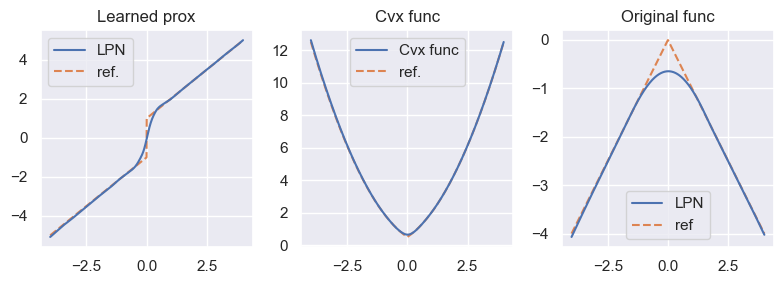

In [11]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 1

for i in range(1):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(40000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

## Proximal matching loss

We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma=10

iteration 0 loss 0.42401978373527527
iteration 500 loss 1.0
iteration 1000 loss 1.0
iteration 1500 loss 1.0
iteration 2000 loss 1.0
iteration 2500 loss 1.0
iteration 0 loss 1.0
iteration 500 loss 1.0
iteration 1000 loss 1.0
iteration 1500 loss 1.0
iteration 2000 loss 1.0
iteration 2500 loss 1.0
mse 93.26958465576172
mse 0.000916076882276684
mse 3.1322446858439434e-08
mse 5.672462933398181e-12
mse 3.5000205858559674e-12
mse 3.5989796212665404e-12
mse 3.8525970608160875e-12
mse 4.752339580887943e-12
mse 5.447488380522225e-12
mse 7.128006952045185e-12
final mse 9.070614051531756e-12
(1000,) (1000,) (1000,) (1000,)


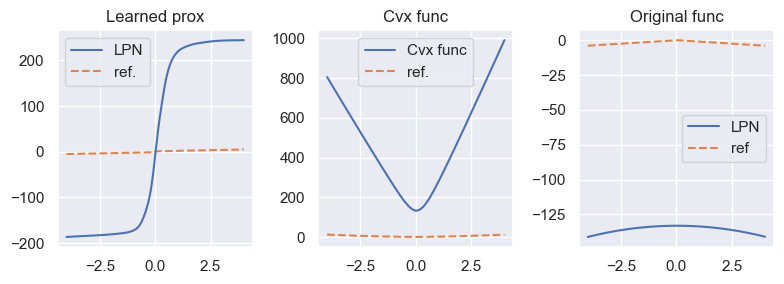

In [12]:
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 0
gamma_loss = 10

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-3

for i in range(3000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(3000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=5

iteration 0 loss 1.0


iteration 500 loss 1.0
iteration 1000 loss 1.0
iteration 1500 loss 1.0
iteration 2000 loss 1.0
iteration 2500 loss 1.0
iteration 3000 loss 1.0
iteration 3500 loss 1.0
iteration 4000 loss 1.0
iteration 4500 loss 1.0
iteration 5000 loss 1.0
iteration 5500 loss 1.0
mse 93.26958465576172
mse 0.000916076882276684
mse 3.1322446858439434e-08
mse 5.672462933398181e-12
mse 3.5000205858559674e-12
mse 3.5989796212665404e-12
mse 3.8525970608160875e-12
mse 4.752339580887943e-12
mse 5.447488380522225e-12
mse 7.128006952045185e-12
final mse 9.070614051531756e-12
(1000,) (1000,) (1000,) (1000,)


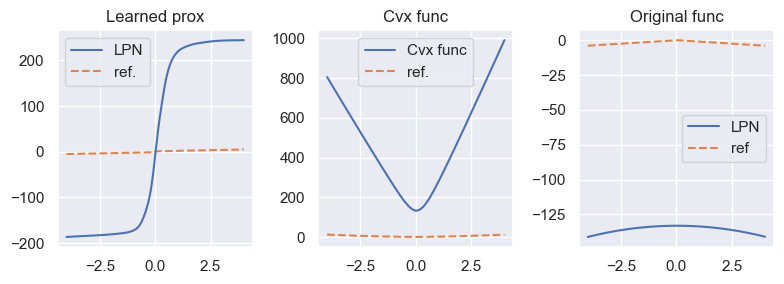

In [13]:
gamma_loss = 5

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(6000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=1

iteration 0 loss 1.0
iteration 500 loss 1.0
iteration 1000 loss 1.0
iteration 1500 loss 1.0
iteration 2000 loss 1.0
iteration 2500 loss 1.0
iteration 3000 loss 1.0
iteration 3500 loss 1.0
iteration 4000 loss 1.0
iteration 4500 loss 1.0
iteration 5000 loss 1.0
iteration 5500 loss 1.0
iteration 6000 loss 1.0
iteration 6500 loss 1.0
iteration 7000 loss 1.0
iteration 7500 loss 1.0
iteration 8000 loss 1.0
iteration 8500 loss 1.0
iteration 9000 loss 1.0
iteration 9500 loss 1.0
mse 93.26958465576172
mse 0.000916076882276684
mse 3.1322446858439434e-08
mse 5.672462933398181e-12
mse 3.5000205858559674e-12
mse 3.5989796212665404e-12
mse 3.8525970608160875e-12
mse 4.752339580887943e-12
mse 5.447488380522225e-12
mse 7.128006952045185e-12
final mse 9.070614051531756e-12
(1000,) (1000,) (1000,) (1000,)


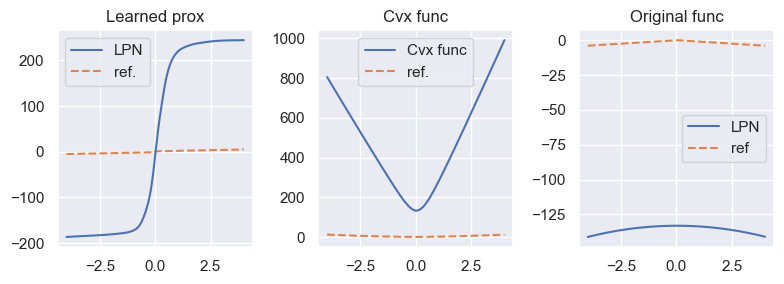

In [14]:
gamma_loss = 1

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(10000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)